,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,821287,43.9,1910698,102.1,1910698,102.1
Vcells,3957328,30.2,89297956,681.3,139337504,1063.1


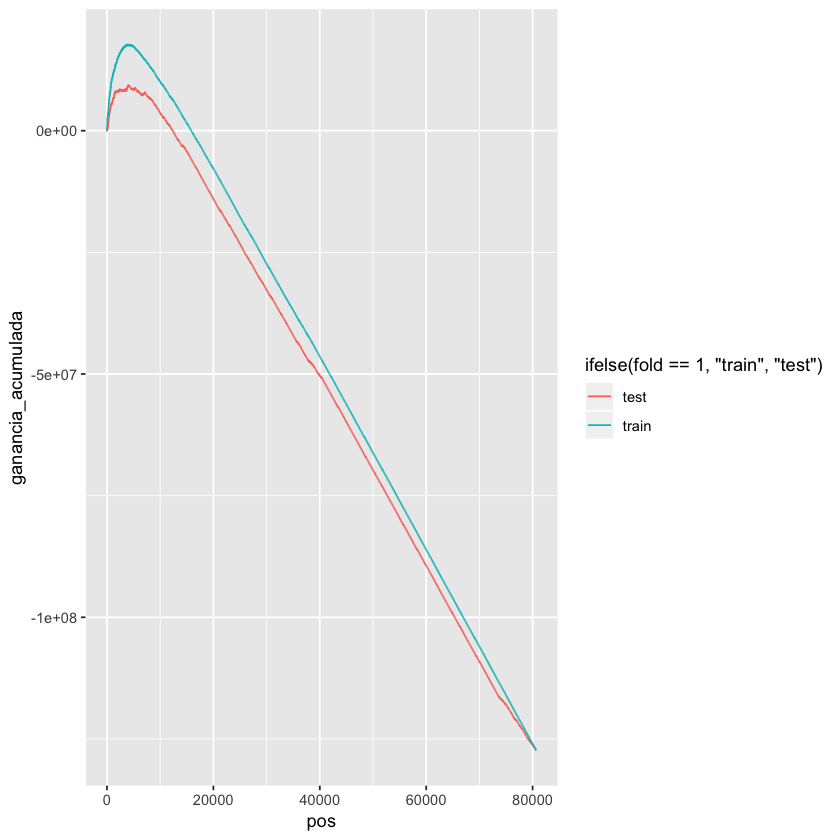

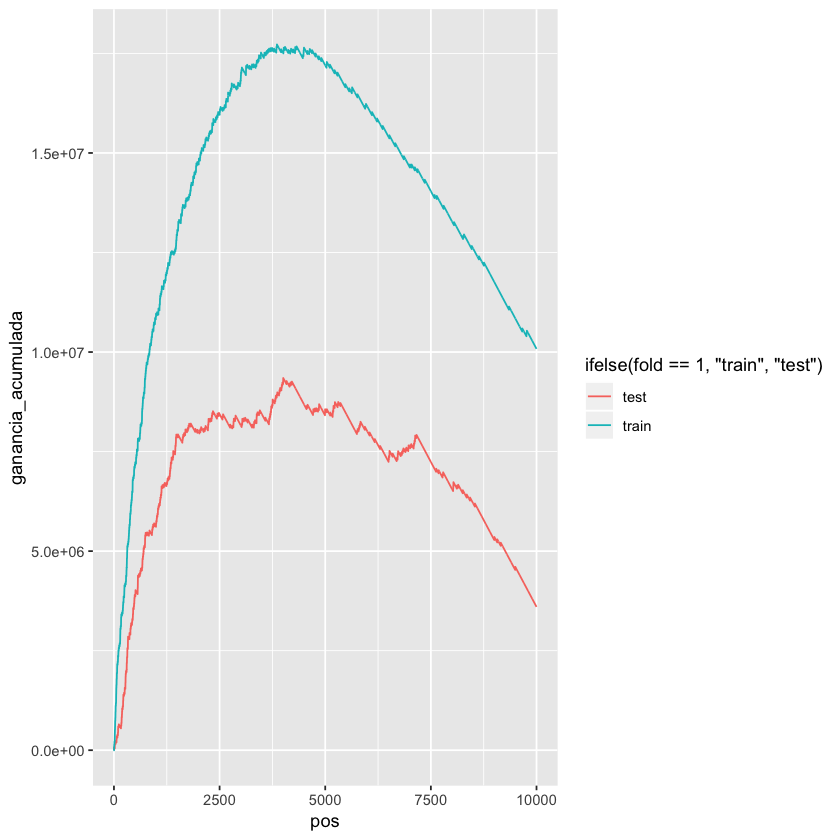

In [7]:
#Este script está pensado para correr en Google Cloud
# debe  cambiase el setwd() si se desea correr en Windows
#Grafico de la ganancia

rm( list=ls() )  #Borro todos los objetos
gc()   #Garbage Collection

#cargo las librerias que necesito
require("data.table")
require("rpart")
require("ggplot2")

#------------------------------------------------------------------------------
#particionar agrega una columna llamada fold a un dataset que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30), agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30 

particionar  <- function( data,  division, agrupa="",  campo="fold", start=1, seed=NA )
{
  if( !is.na(seed) )   set.seed( seed )

  bloque  <- unlist( mapply(  function(x,y) { rep( y, x )} ,   division,  seq( from=start, length.out=length(division) )  ) )  

  data[ , (campo) :=  sample( rep( bloque, ceiling(.N/length(bloque))) )[1:.N],
          by= agrupa ]
}
#------------------------------------------------------------------------------

#Aqui se debe poner la carpeta de la materia de SU computadora local
#setwd("~/buckets/b1/")  #Establezco el Working Directory

#cargo el dataset
dataset  <- fread("/Users/achain/Documents/github/labo/propio/datasets/competencia1_2022.csv" )

# a partir de ahora solo trabajo con 202101, el mes que tiene clase
dataset  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar


#division 50%, 50%
particionar( dataset, division=c(1,1), agrupa="clase_ternaria", seed= 102191 )  #Cambiar por la primer semilla de cada uno !

# Entreno el modelo
modelo  <- rpart(formula=   "clase_ternaria ~ . -fold",
                 data=      dataset[ fold==1, ], #los datos donde voy a entrenar
                 xval=          0,
                 cp=           -1,
                 minsplit=    300,
                 minbucket=    18,
                 maxdepth=     11  )


#aplico el modelo a los datos de testing
prediccion  <- predict( modelo,   #el modelo que genere recien
                        dataset,  #fold==2  es testing, el 30% de los datos
                        type= "prob") #type= "prob"  es que devuelva la probabilidad

#Aplico el modelo entrenado sobre un  50%  ( fold==1 )  a TODO el dataset
dataset[  , prob_baja2 := prediccion[, "BAJA+2"] ]


#Dibujo las curvas de ganancia
setorder( dataset,  fold,  -prob_baja2 )

#agrego una columna que es la de las ganancias
dataset[ , gan :=  ifelse( clase_ternaria=="BAJA+2", 78000, -2000 ) ]
dataset[ , ganancia_acumulada := cumsum( gan ),  by=fold ]
dataset[ , pos := sequence(.N),  by=fold ]


#primer grafico
ggplot(data = dataset, aes(x = pos, y = ganancia_acumulada, color = ifelse(fold==1, "train", "test")) ) +
    geom_line()


#segundo grafico
ggplot(data = dataset[ pos <= 10000], aes(x = pos, y = ganancia_acumulada, color = ifelse(fold==1, "train", "test")) ) +
    geom_line()


In [2]:
getwd()

[1] "/Users/achain/Documents/github/labo/propio/scripts"